<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/MergedEducation_PeopleperroomSom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

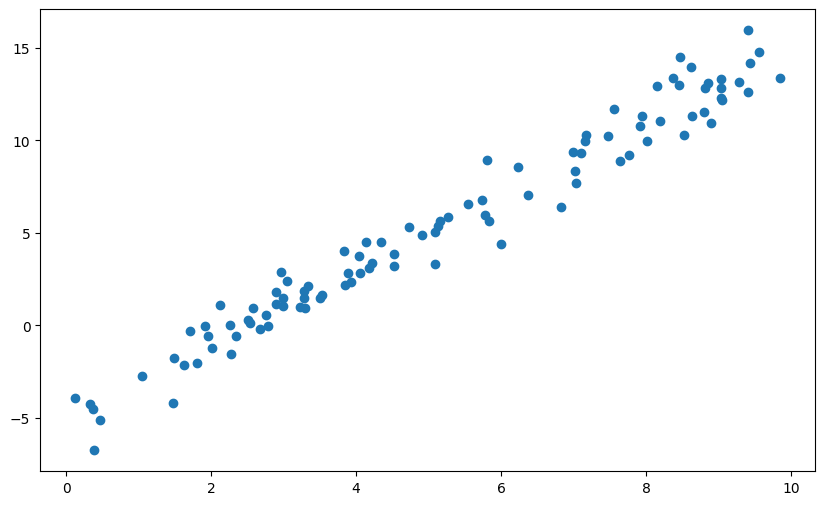

In [28]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("mergednormalized_with_winners_cleaned-2.csv")

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative'])]#Filtering the data to train and display conservative and labour
party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    # 'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    # 'Green': (0, 0.6, 0.3),         # Dark Green
    # 'The Brexit Party': (0.6, 0.2, 0.8) #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(data[features])

robust_scaler = RobustScaler()#Robust scaler used as it handles outliers better than min max scaler
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = filtered_data[labeling_columns].values

print(normalized_df.head())
print(normalized_df.shape[0])

   Over 0.5 and up to 1.0 people per room - Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
0                                           1.082315                                                                                                                                                                                            
1                                           0.315769                                                                                                                                                                                            
2                                          -1.254364                                                                                                                                                                                            
3                                   

In [32]:

# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))# thumb rule for the number of nuerons within a dataset
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.213, learning_rate=0.435,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)#Used random so that everything within the dataset may not be suppressed unlike pca makes the dataset to be linear.

# Train the SOM
num_iterations = 3500#optimal number of iterations based on the iterations tuning.
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





 [ 3500 / 3500 ] 100% - 0:00:00 left 
 quantization error: 1.0122596069950869


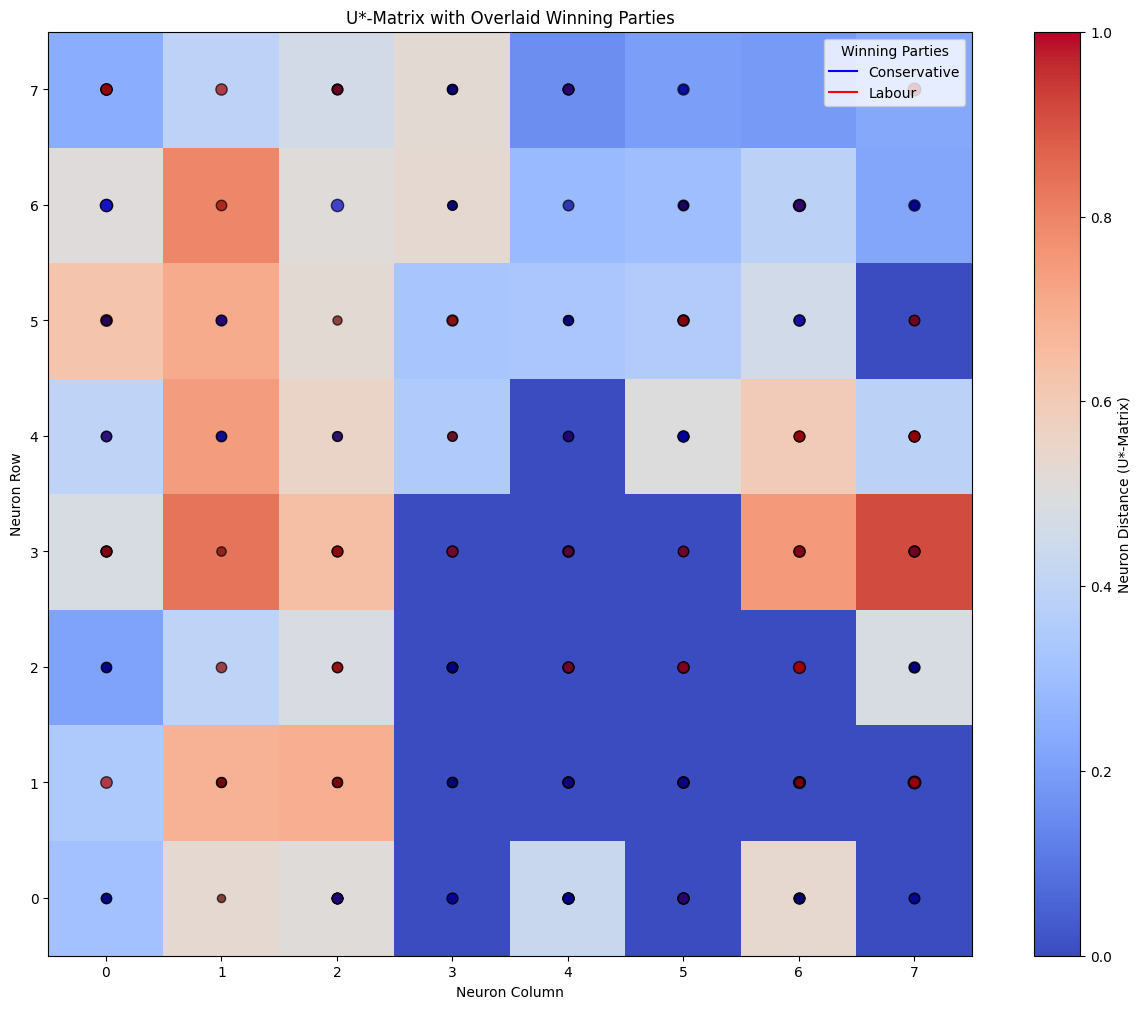

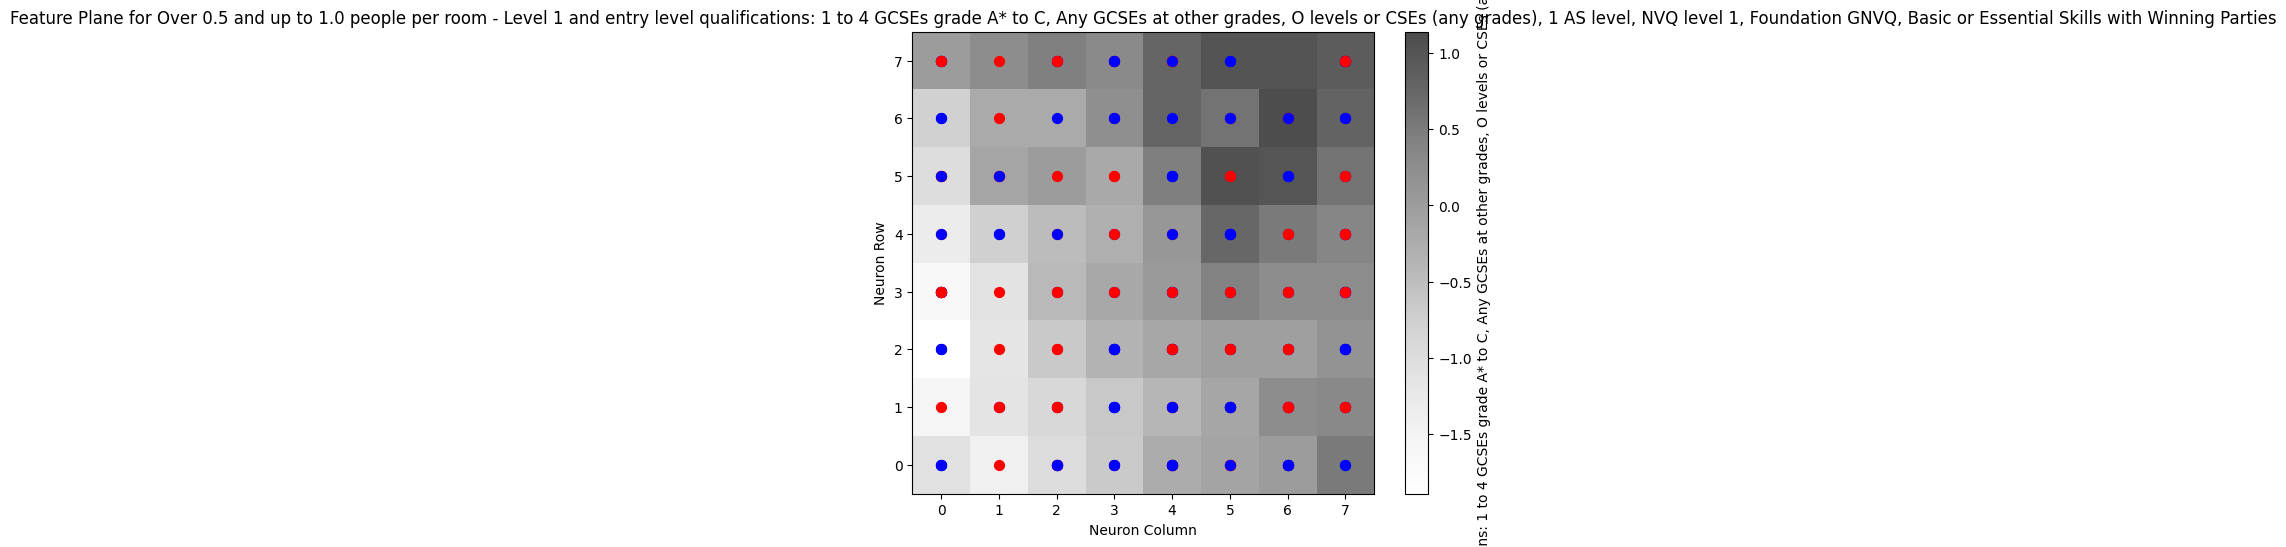

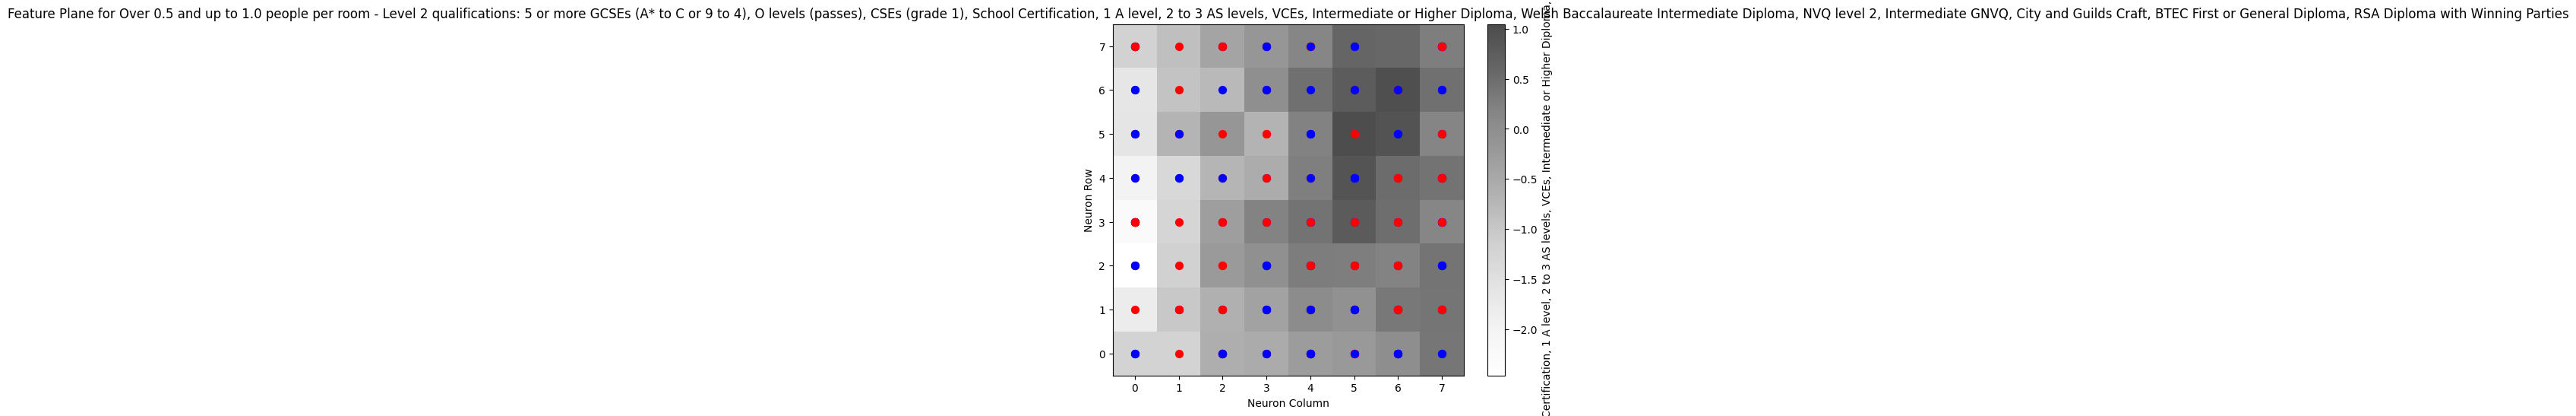

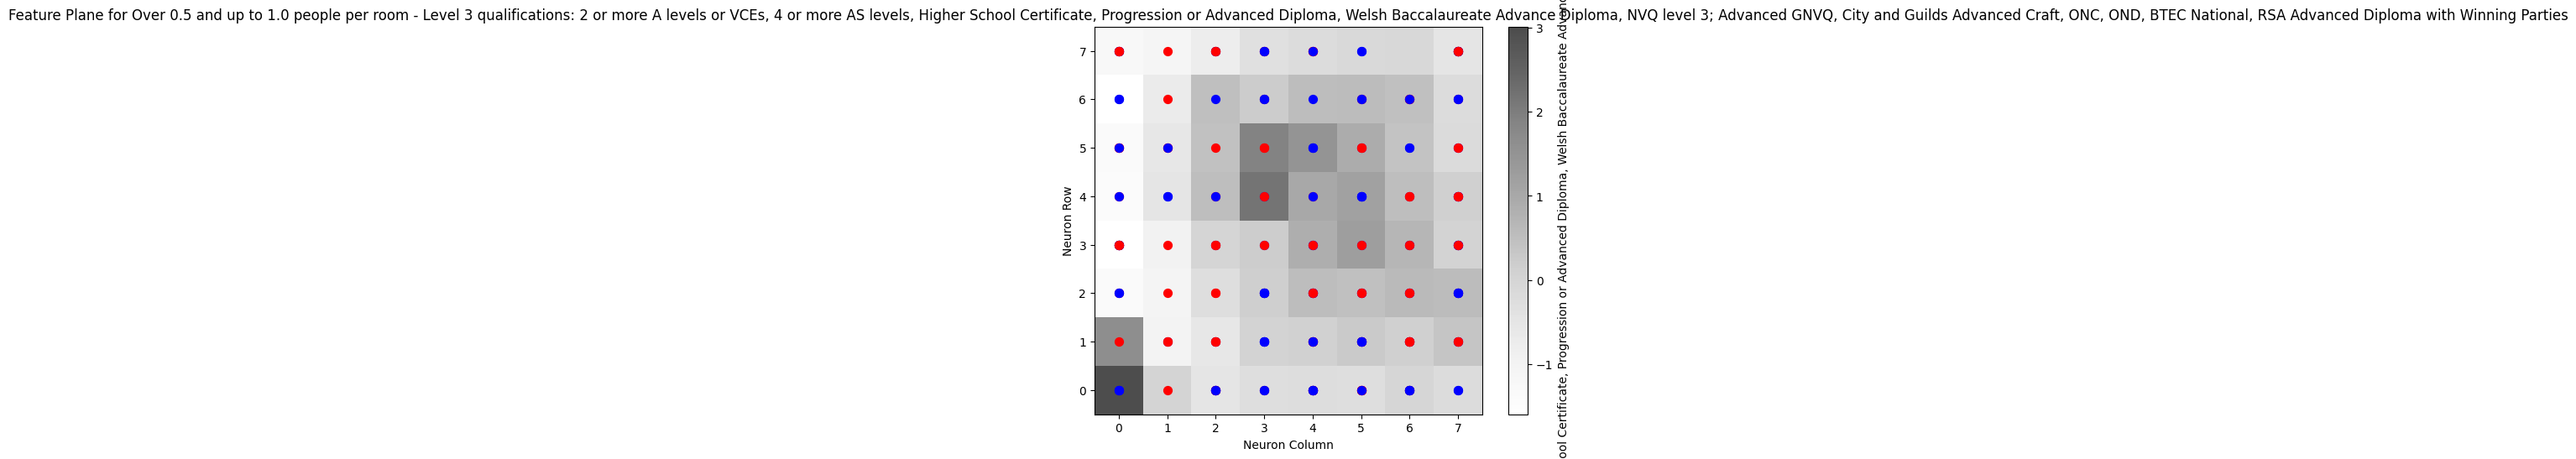

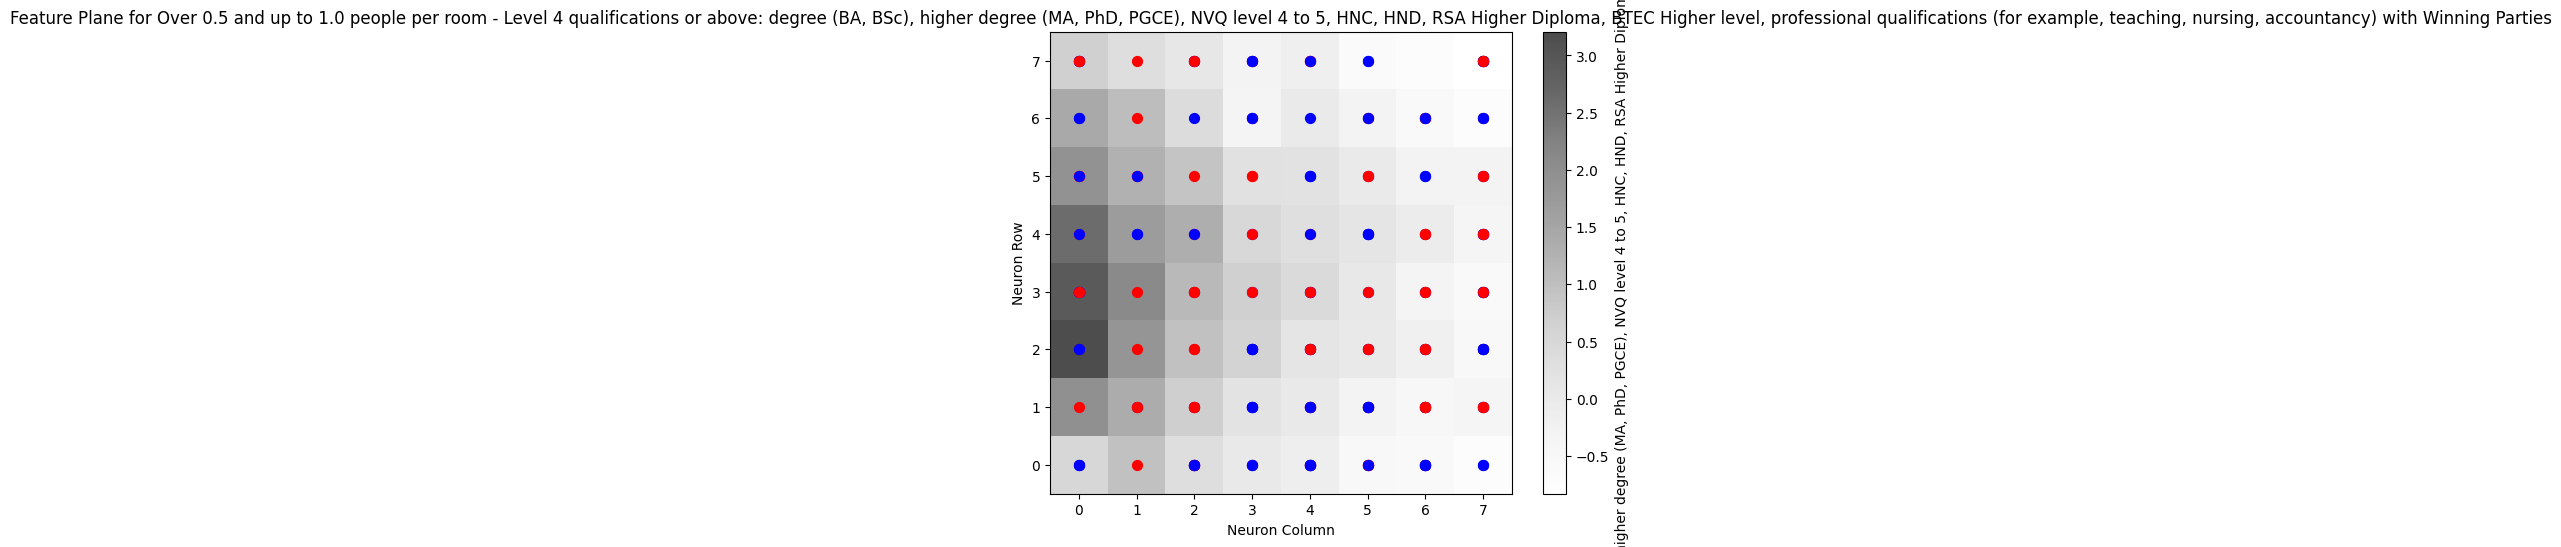

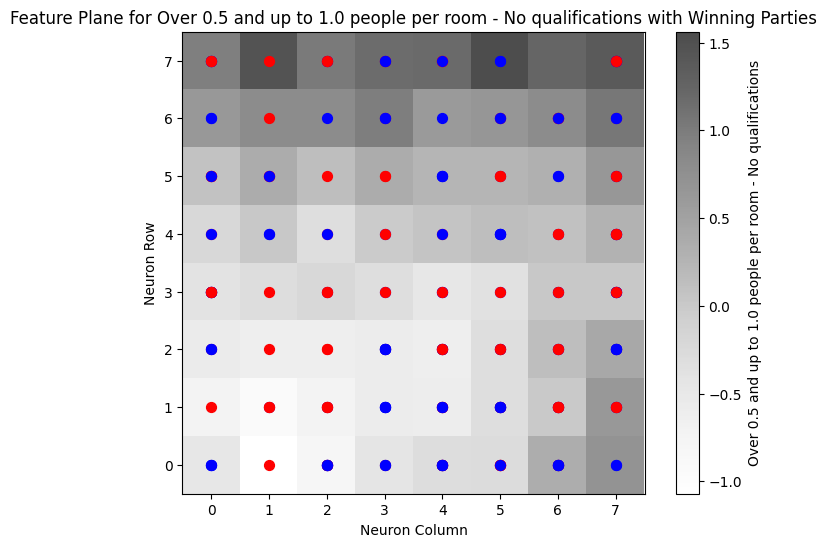

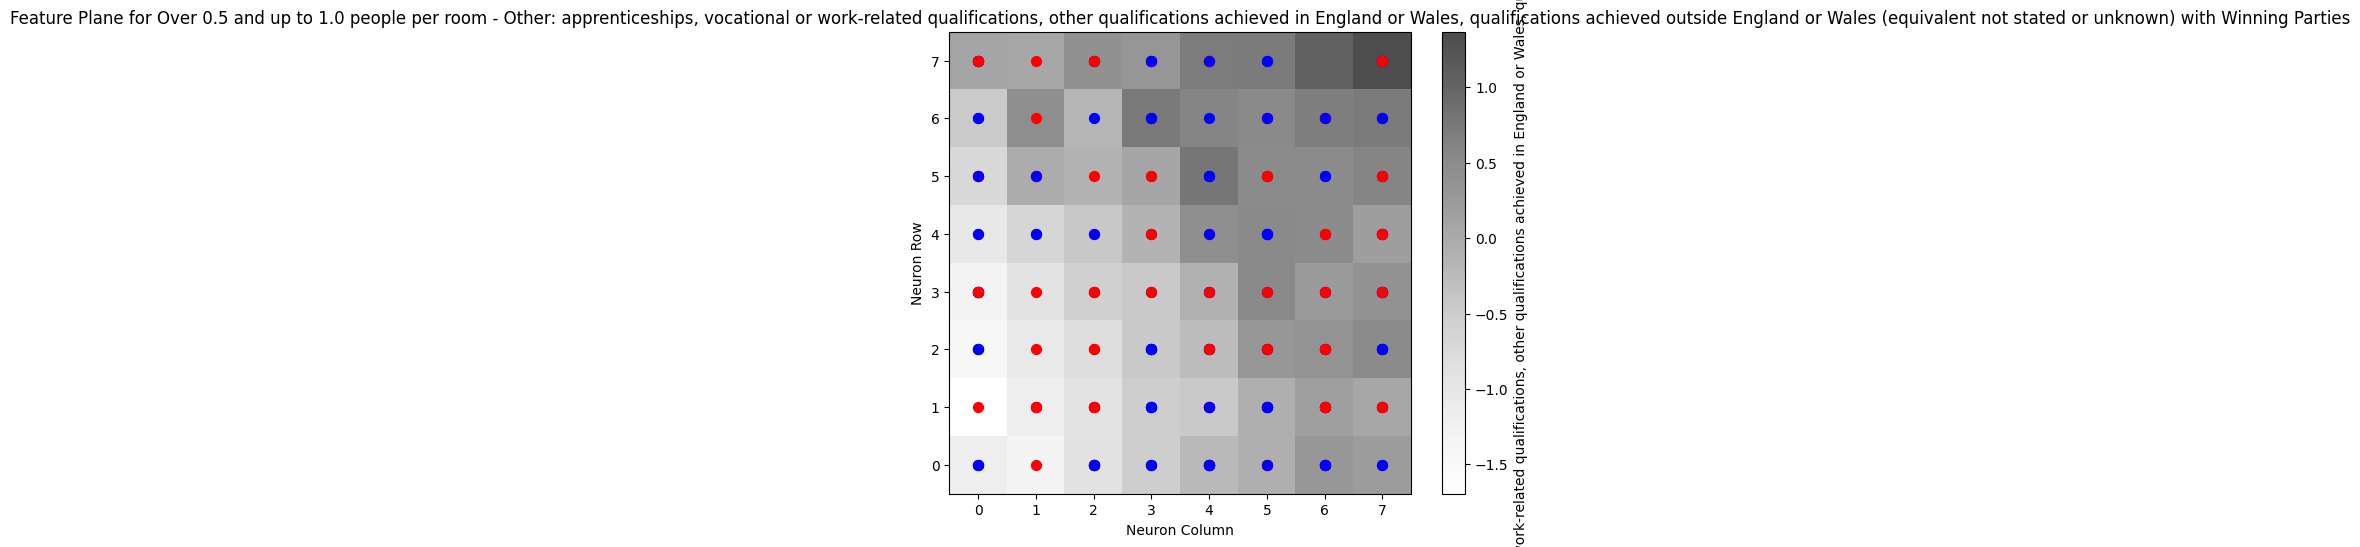

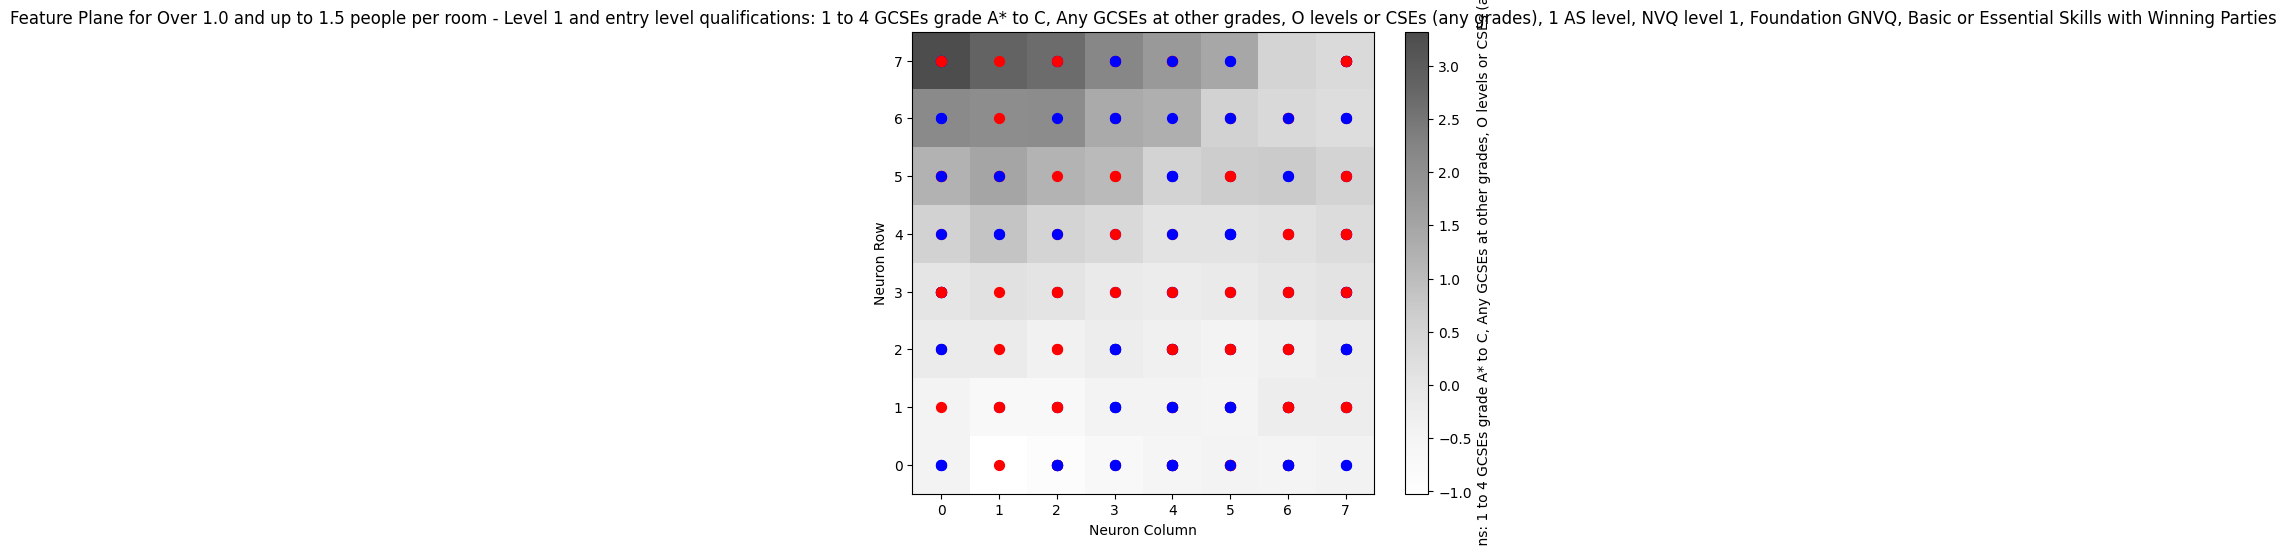

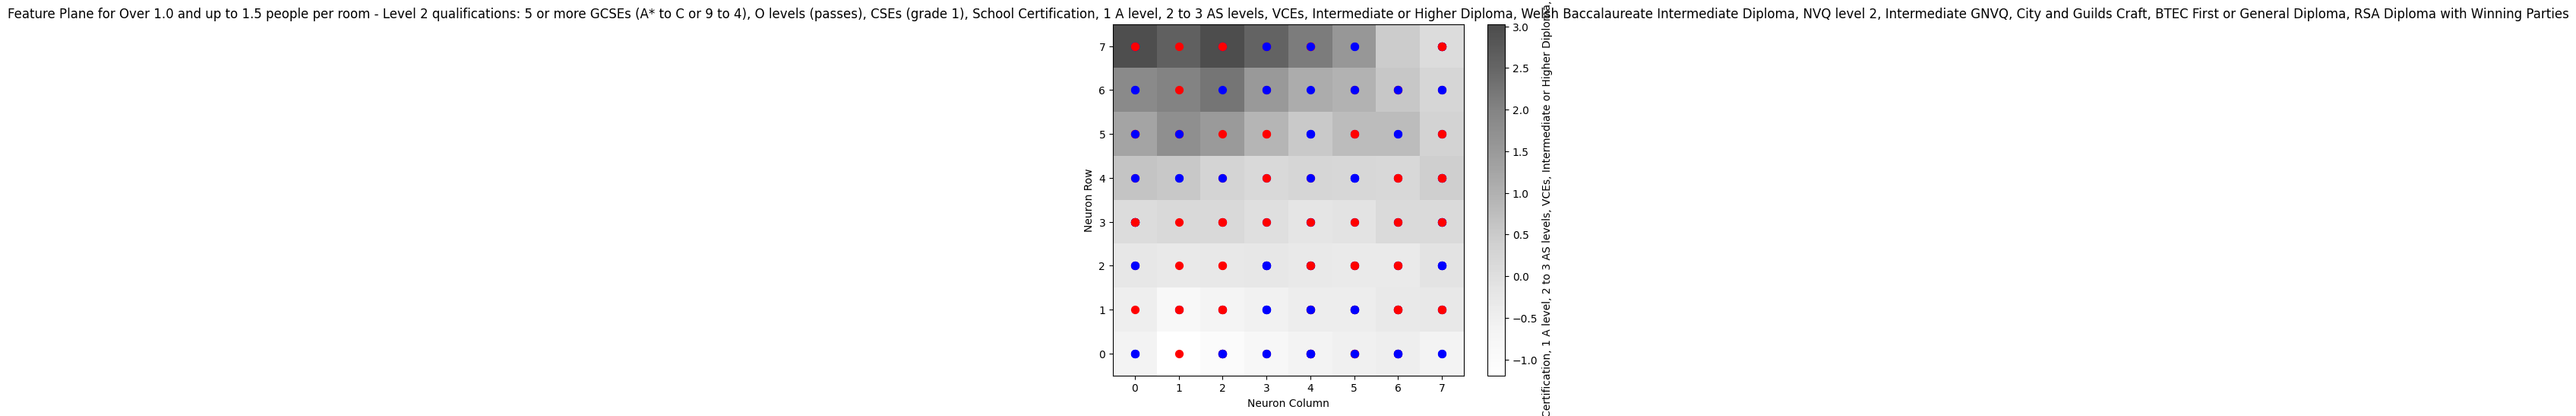

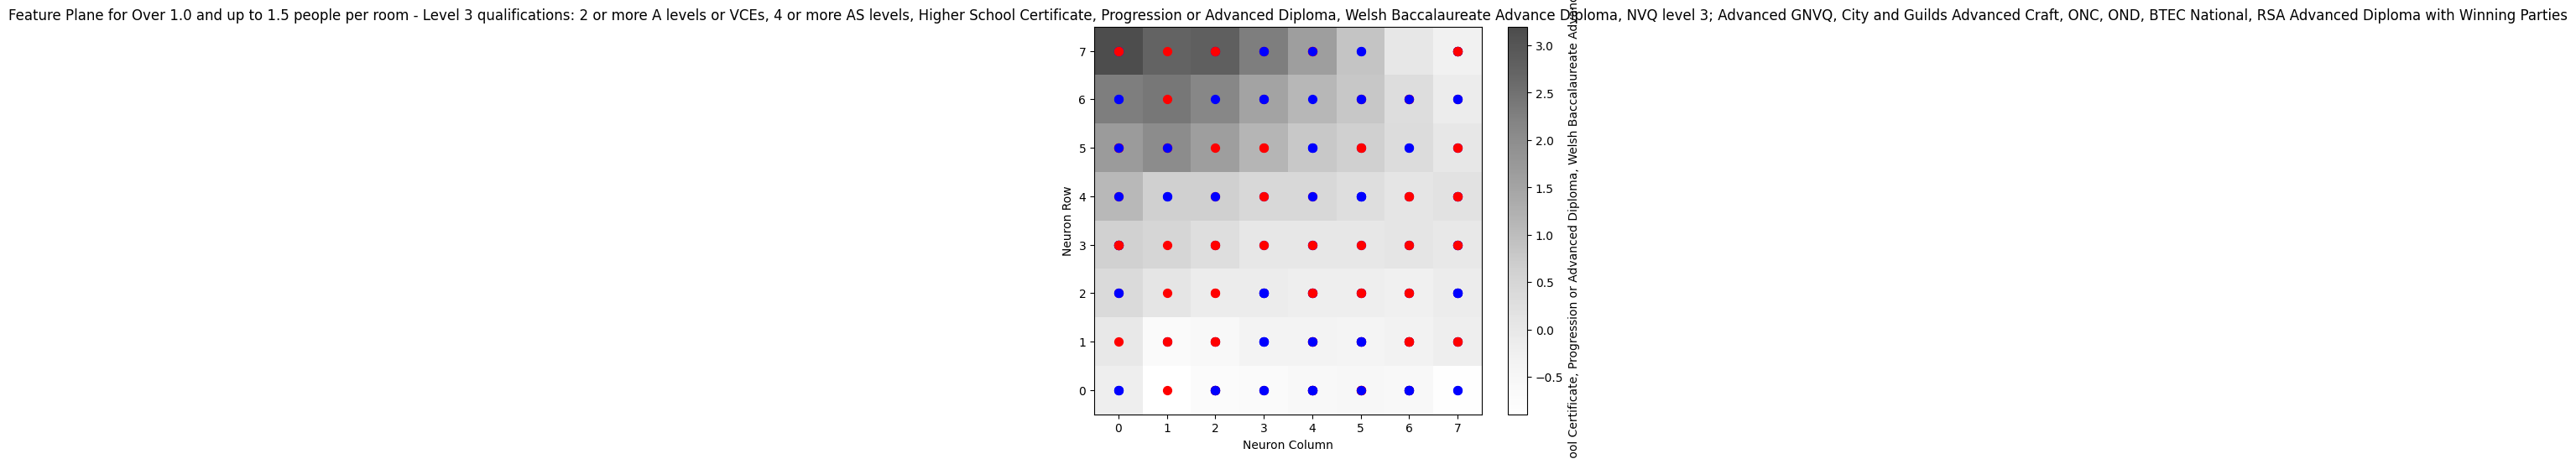

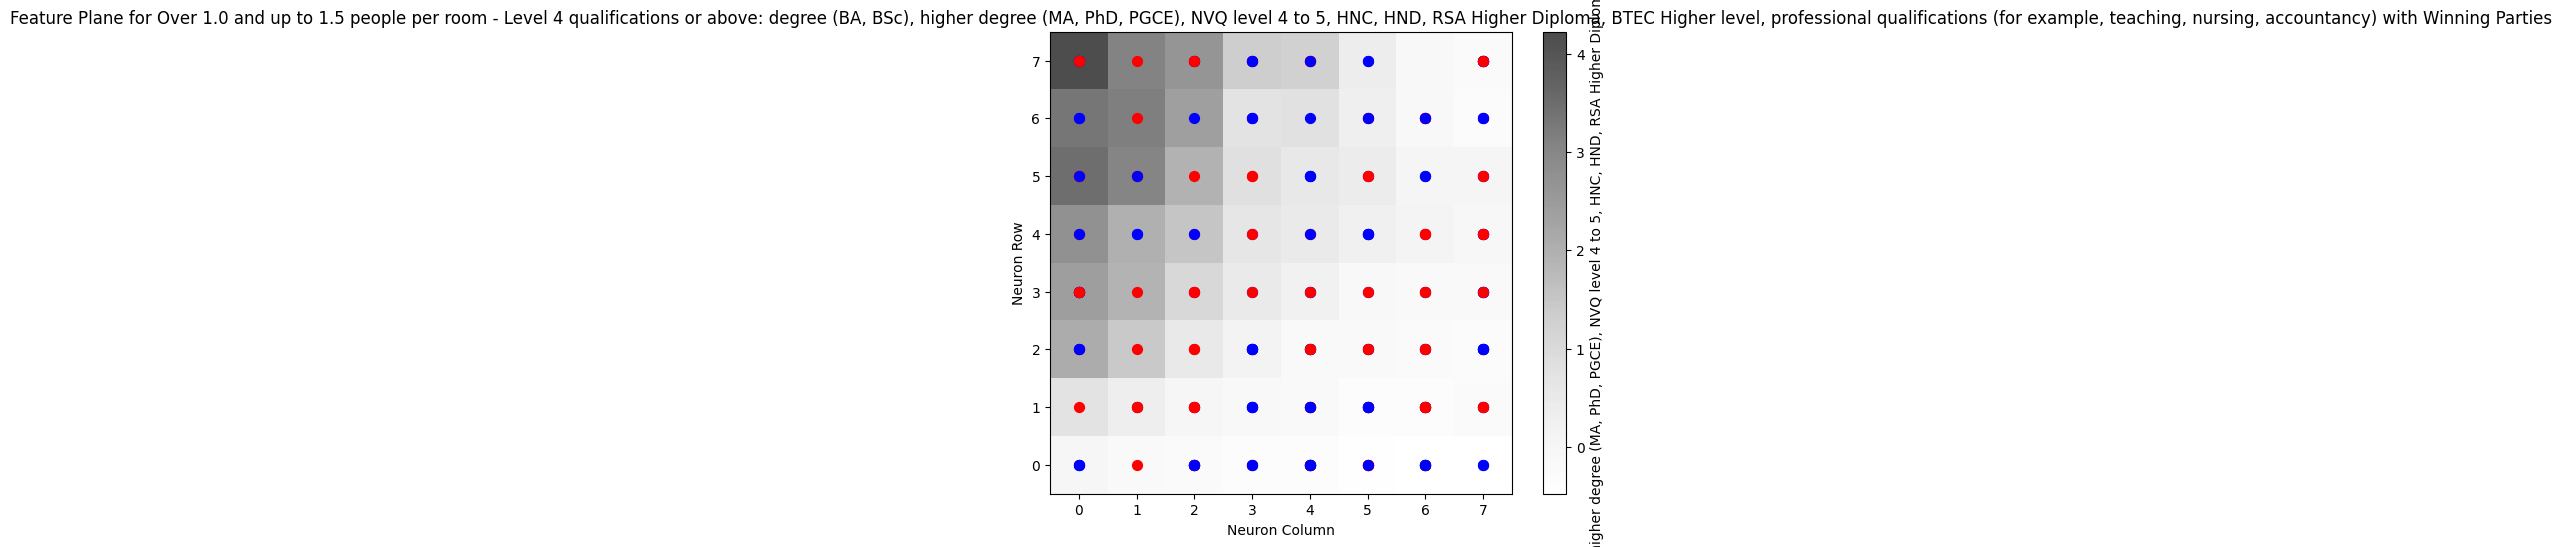

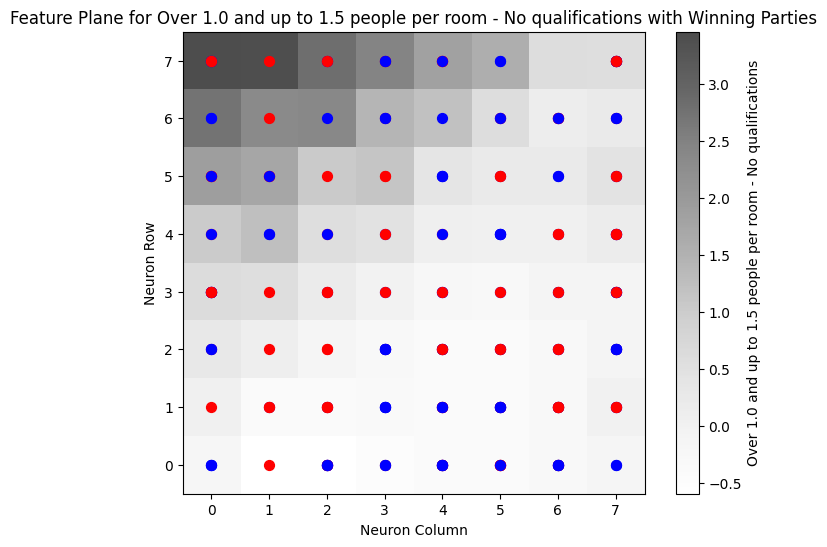

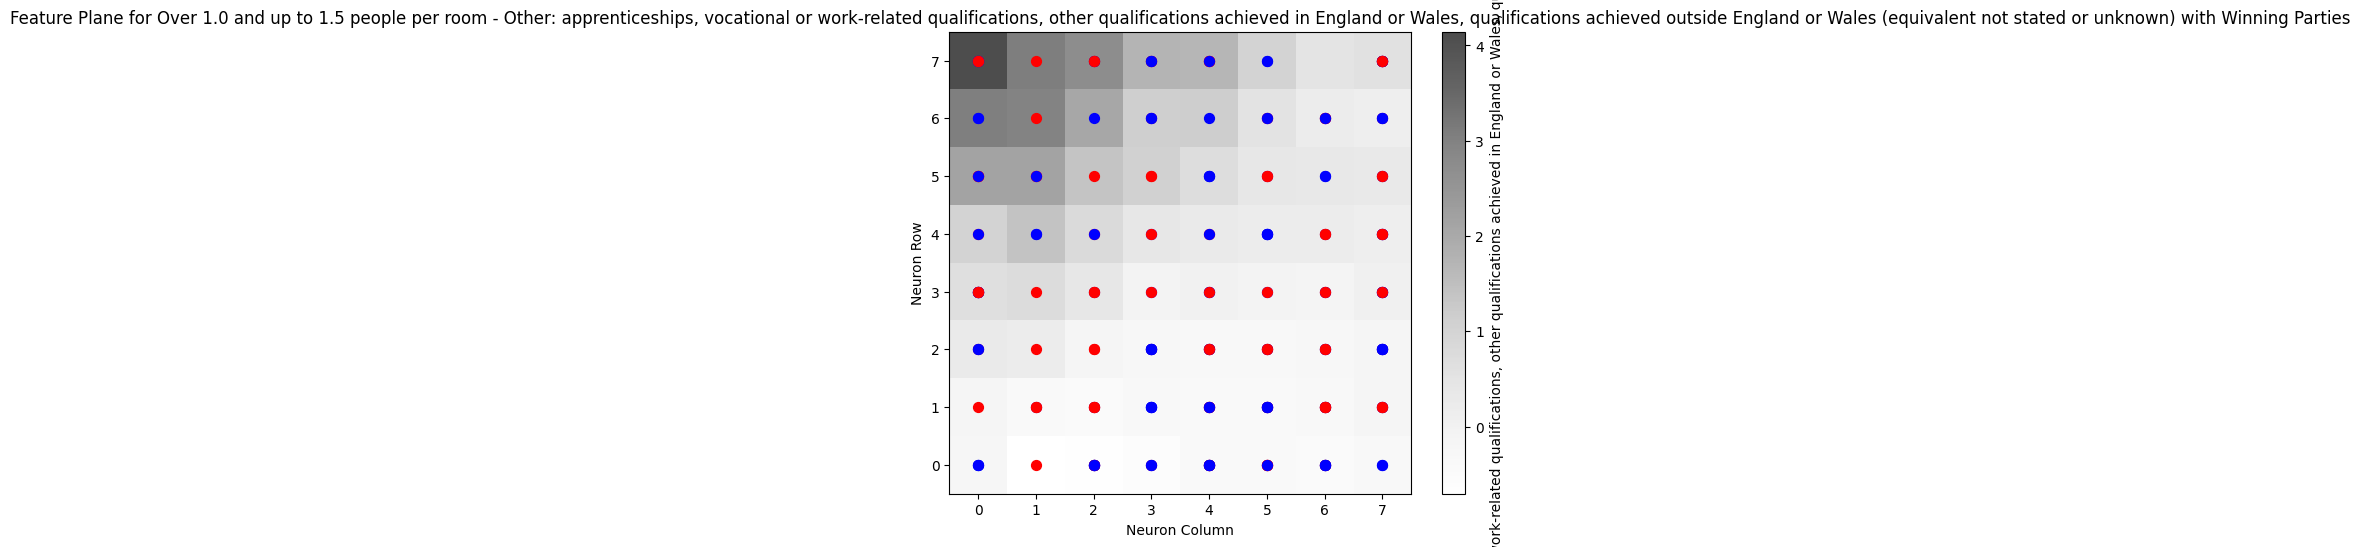

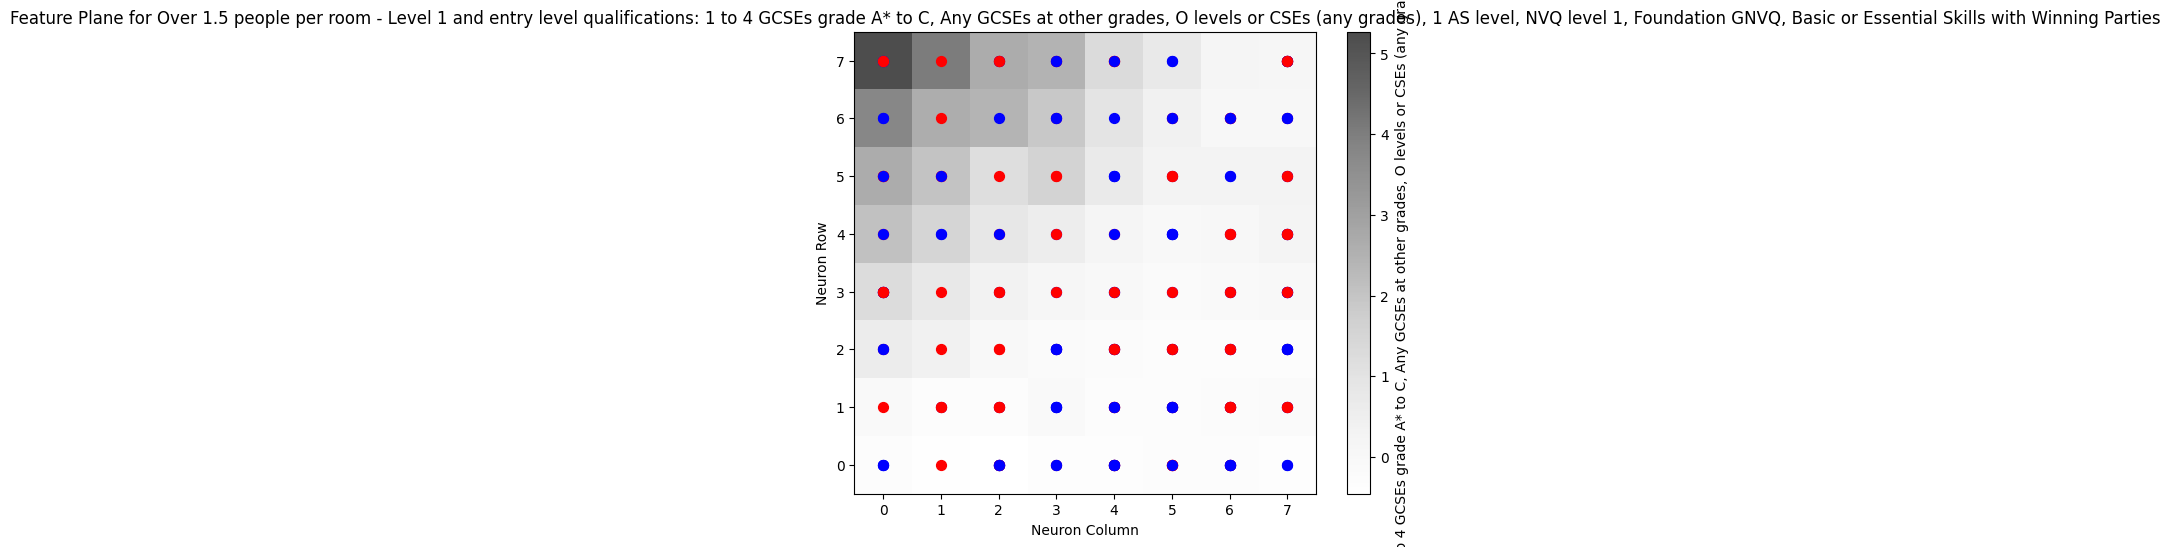

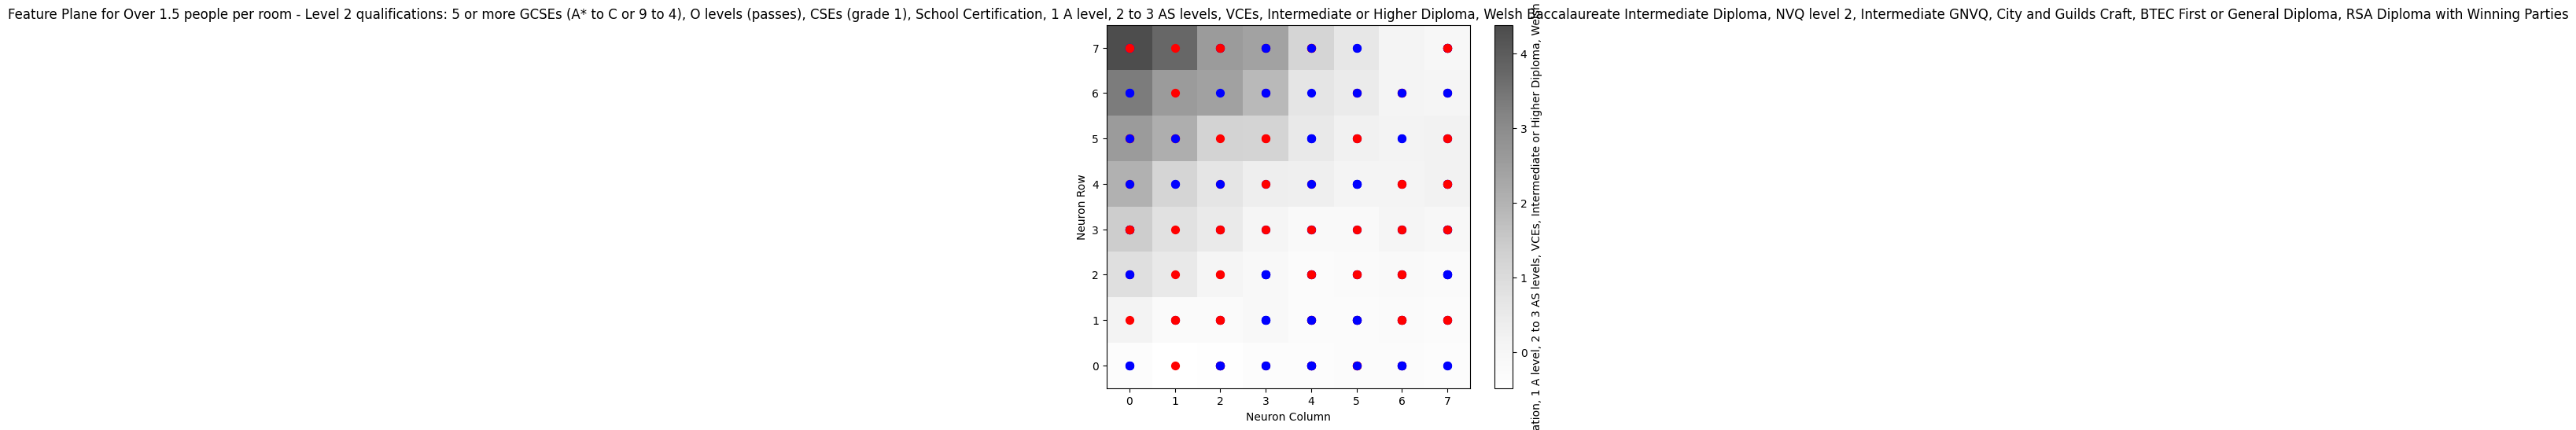

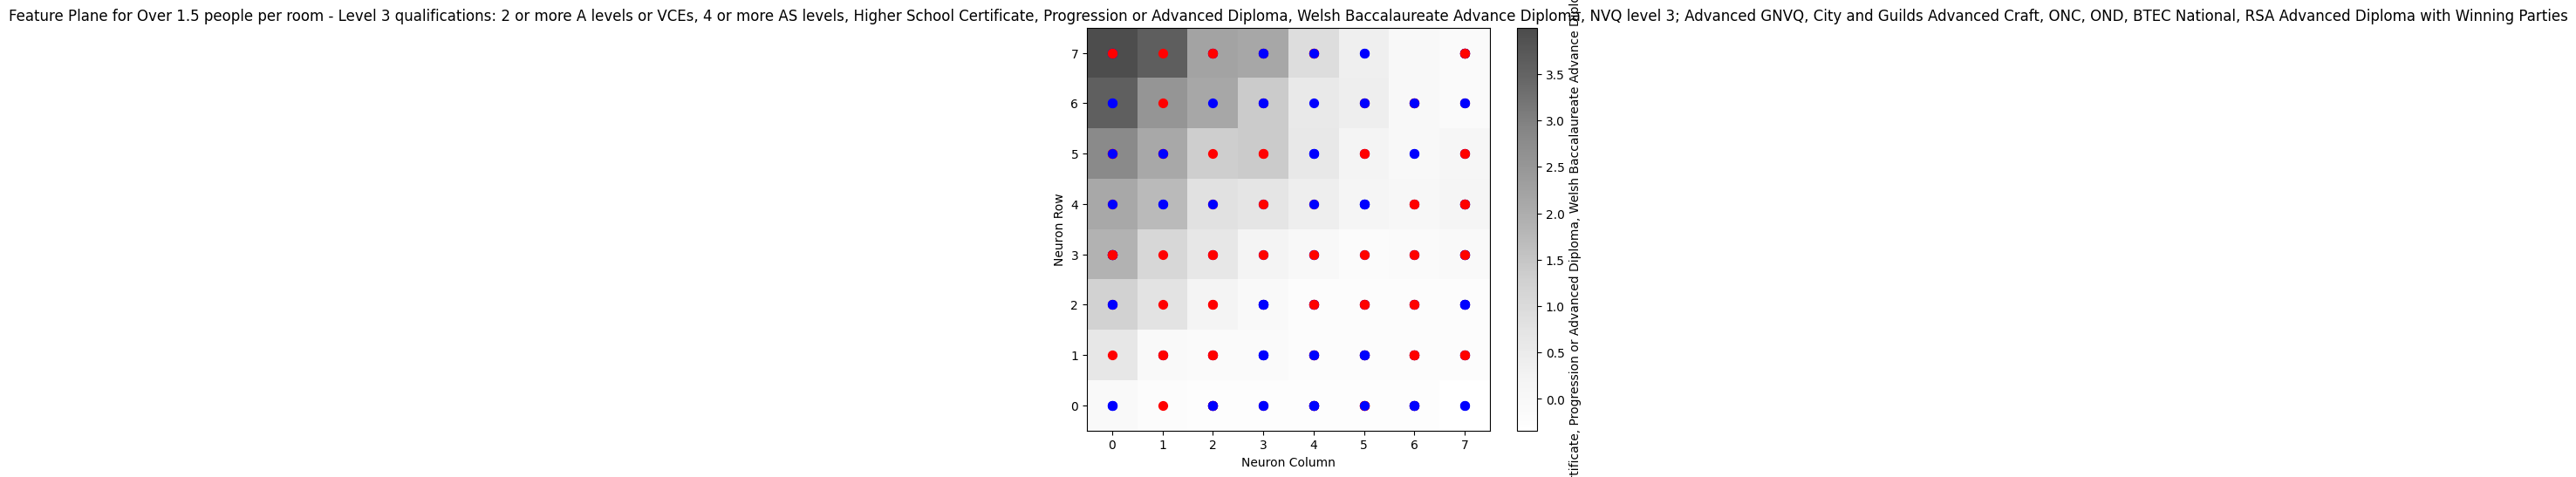

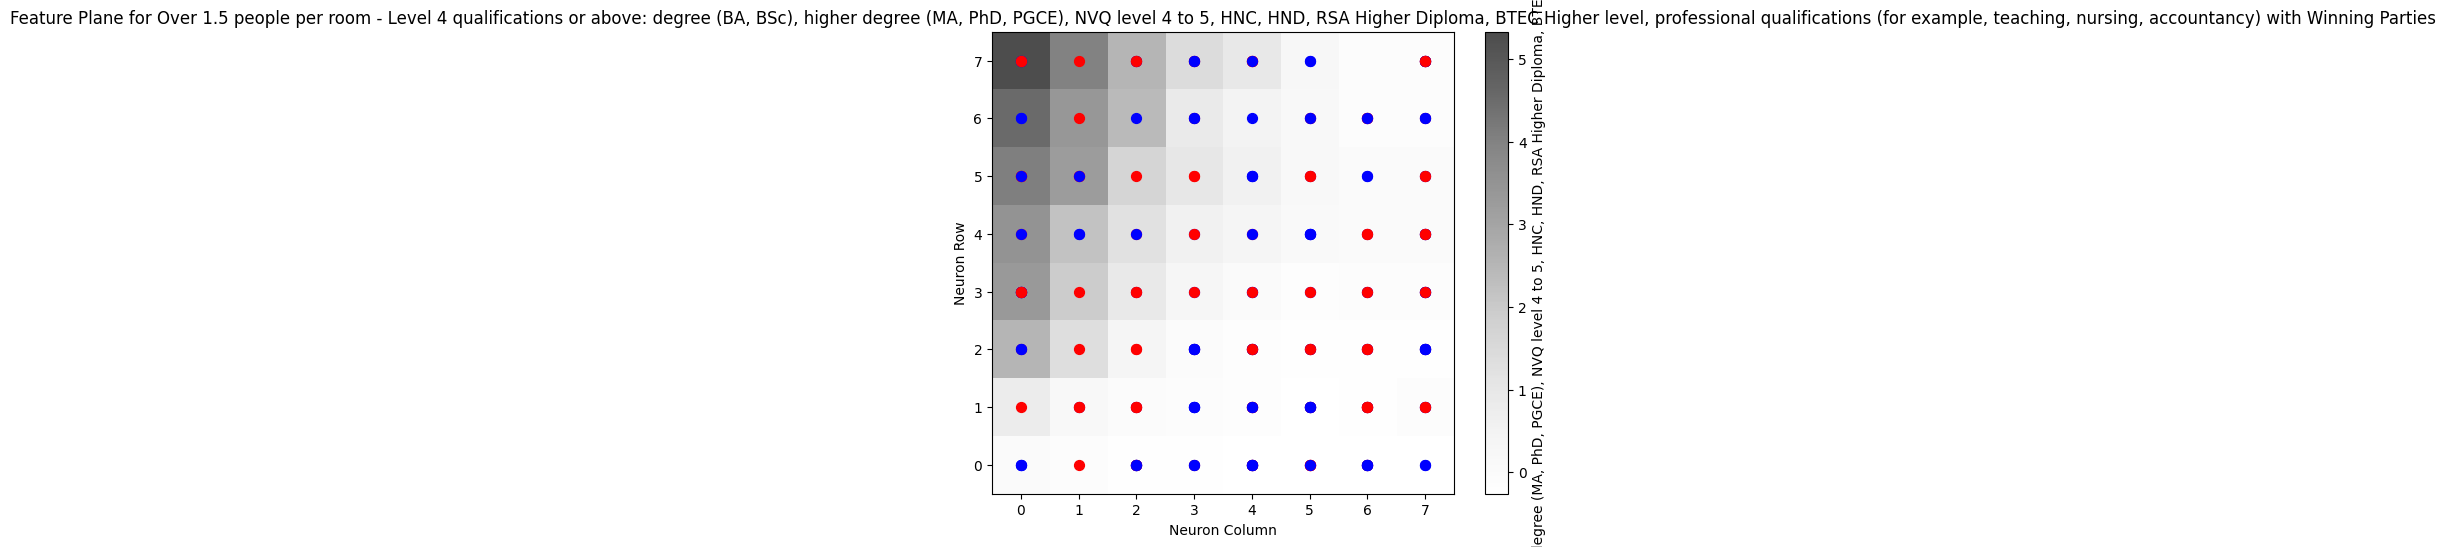

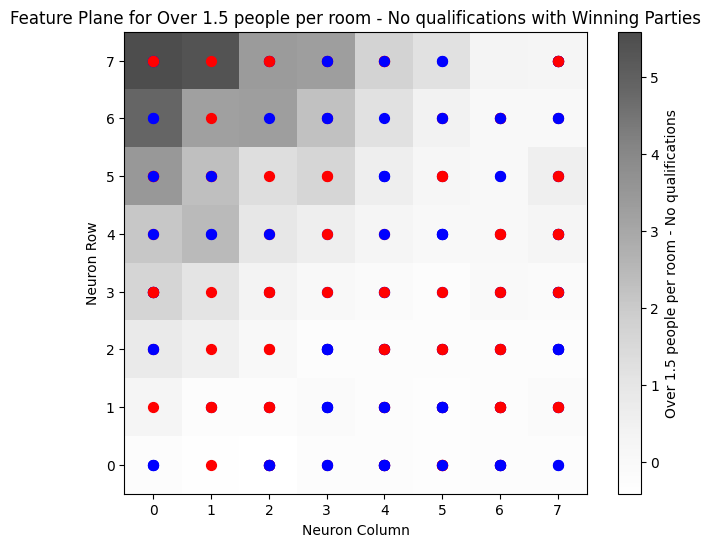

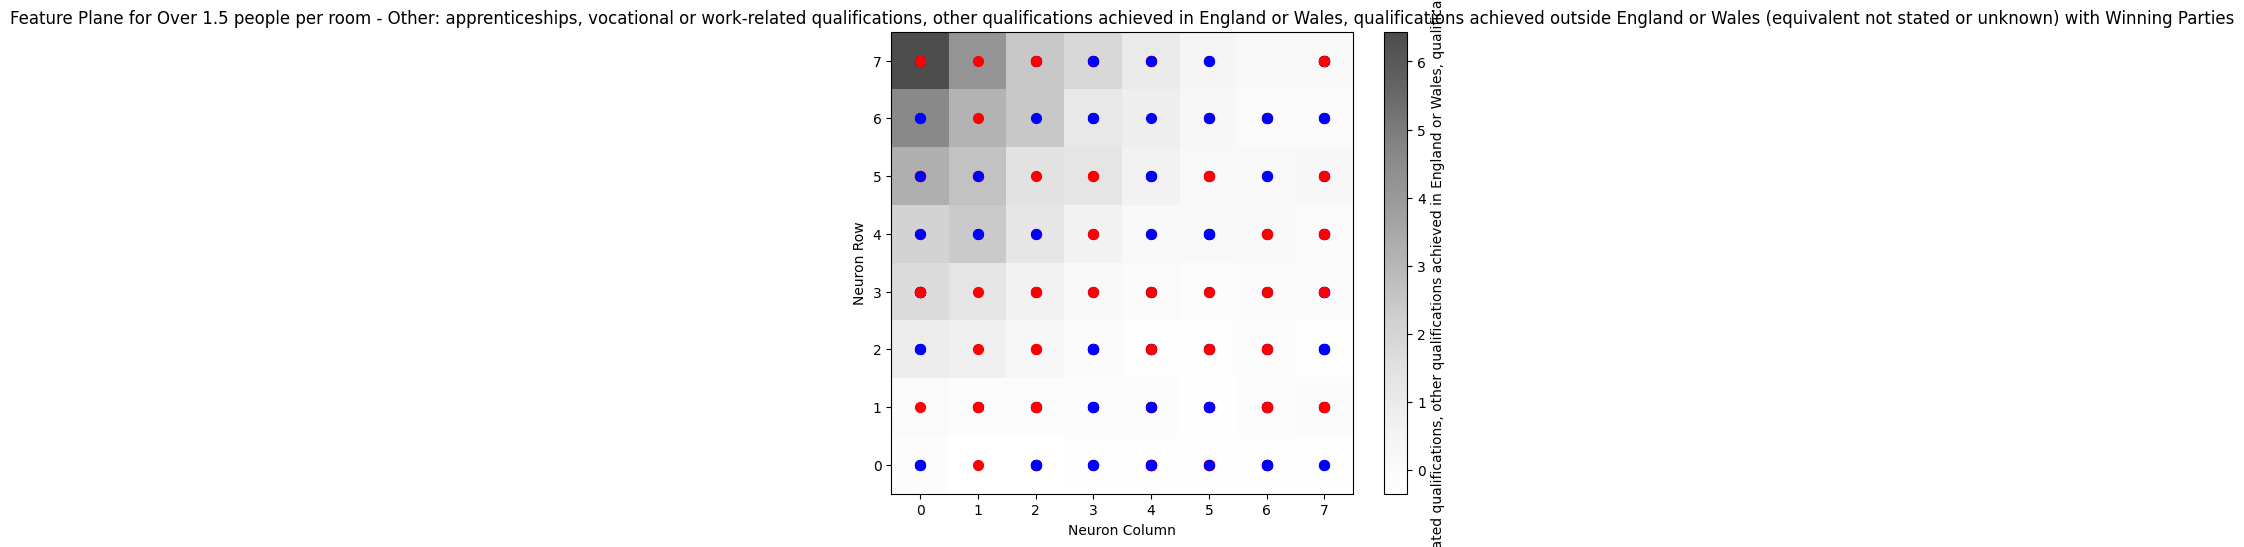

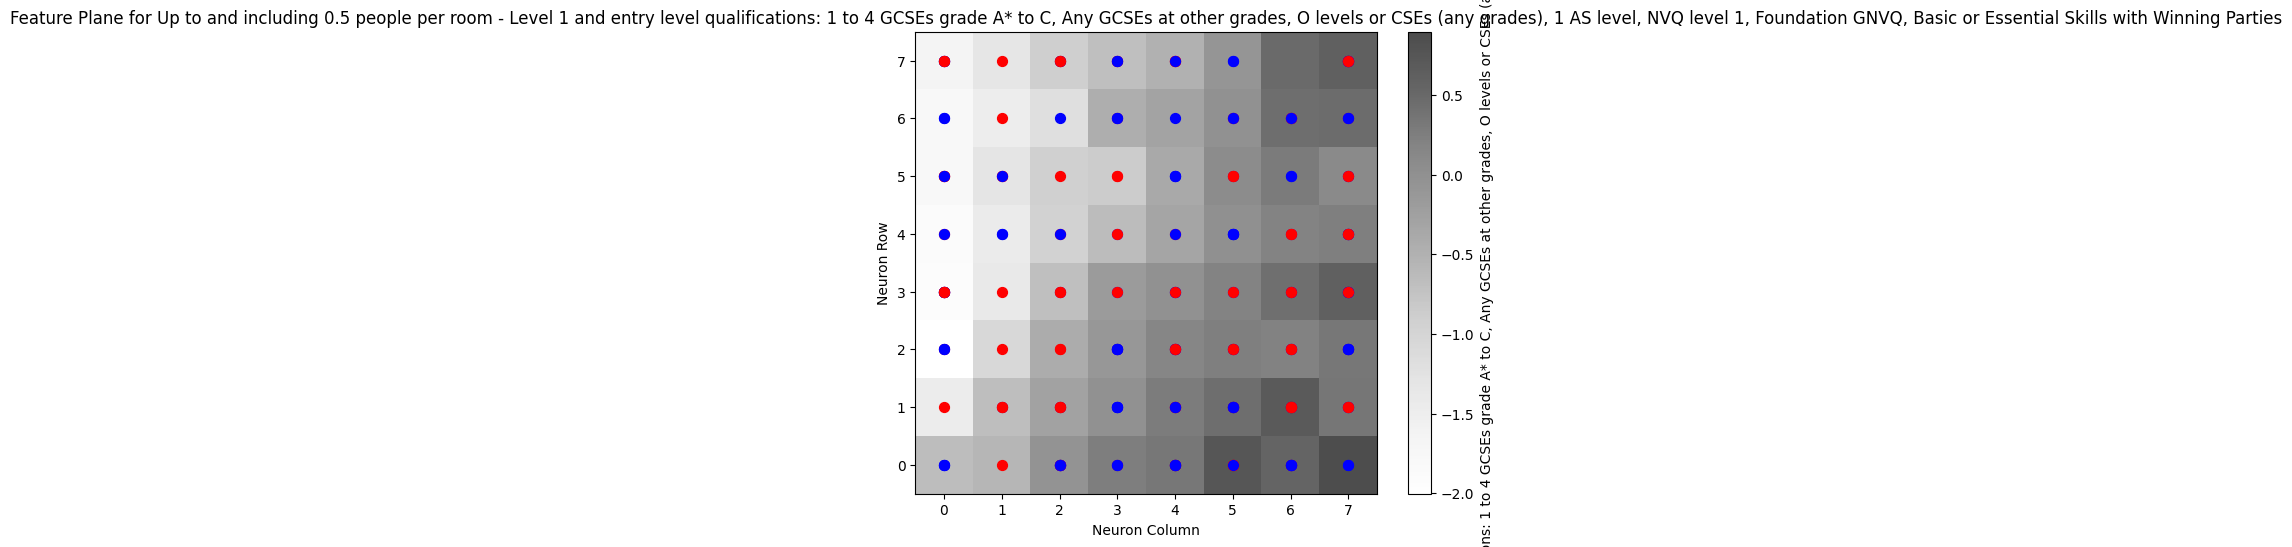

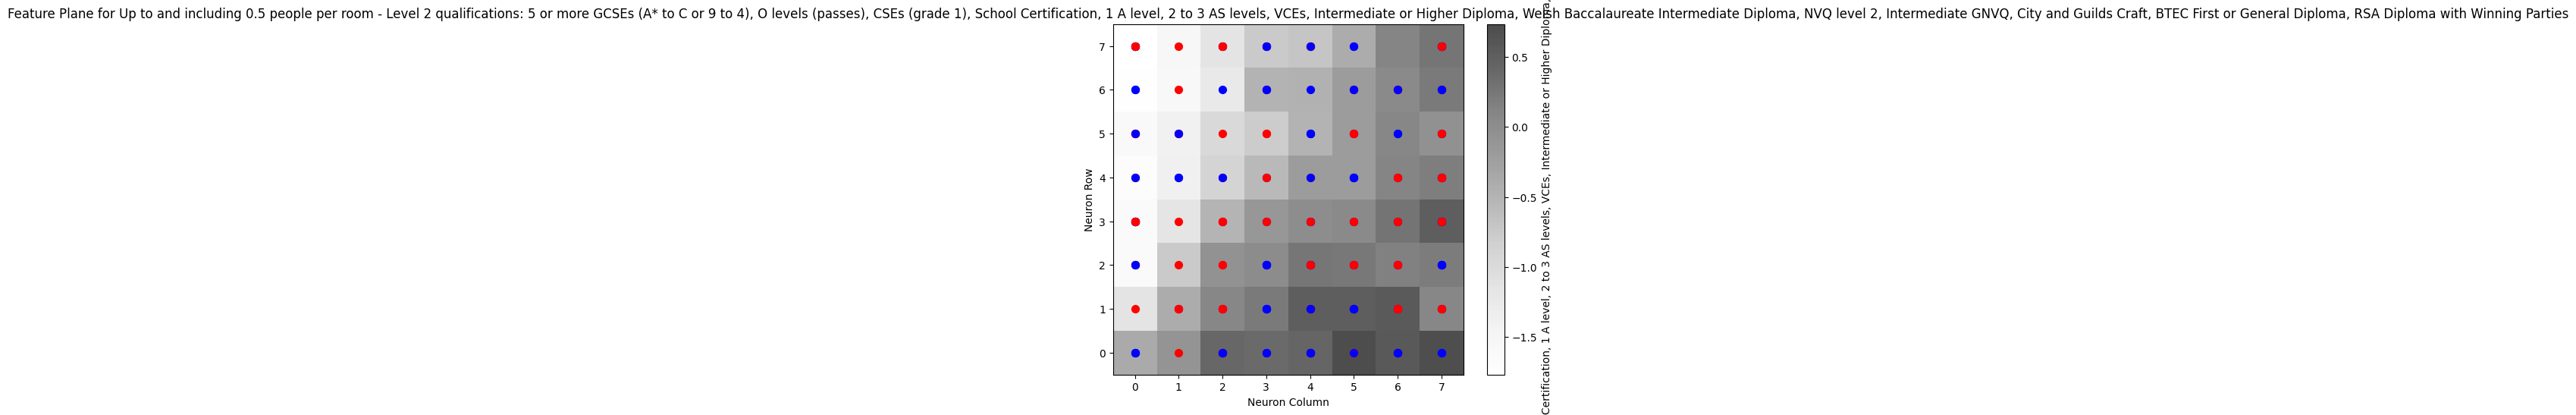

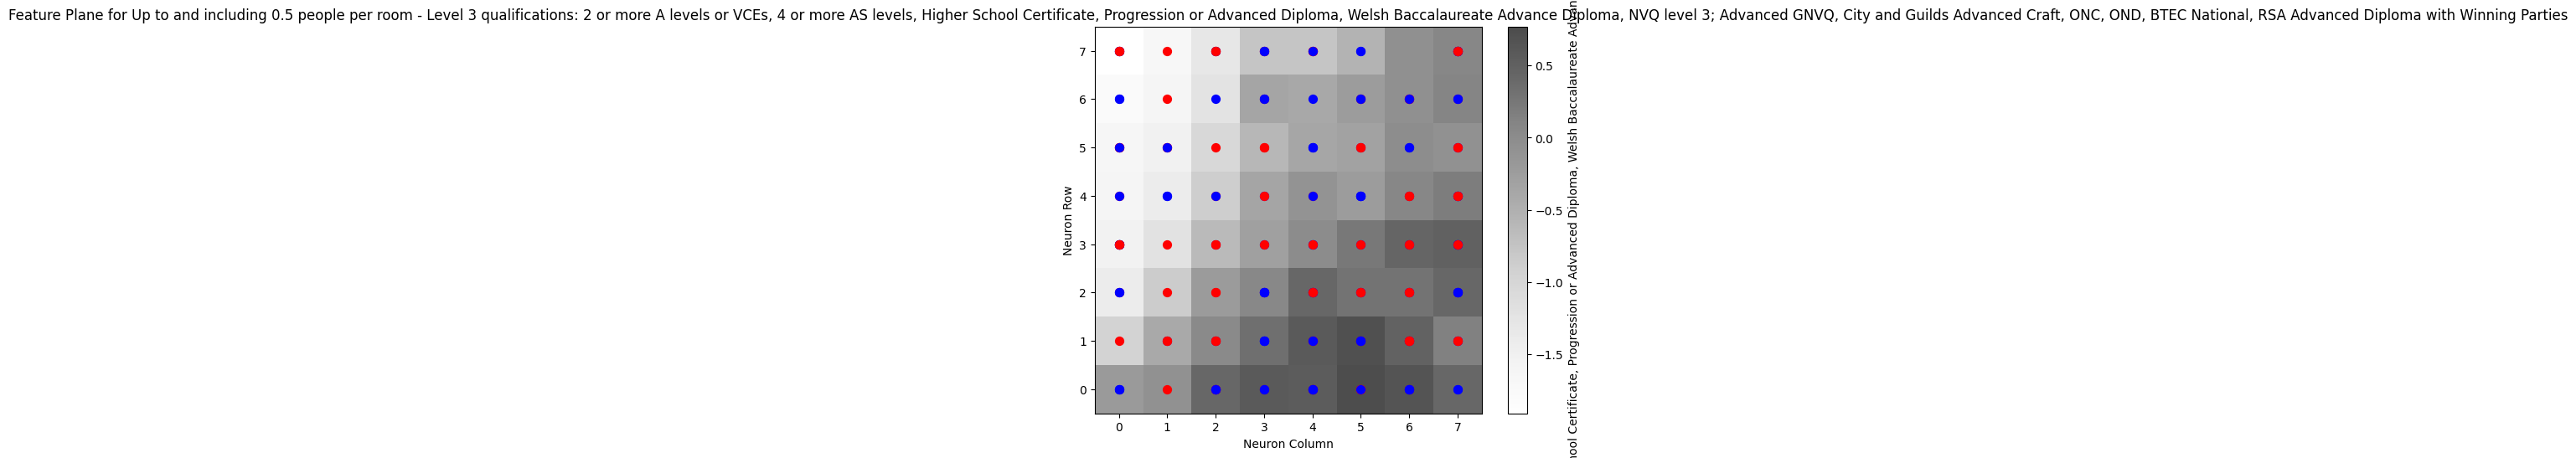

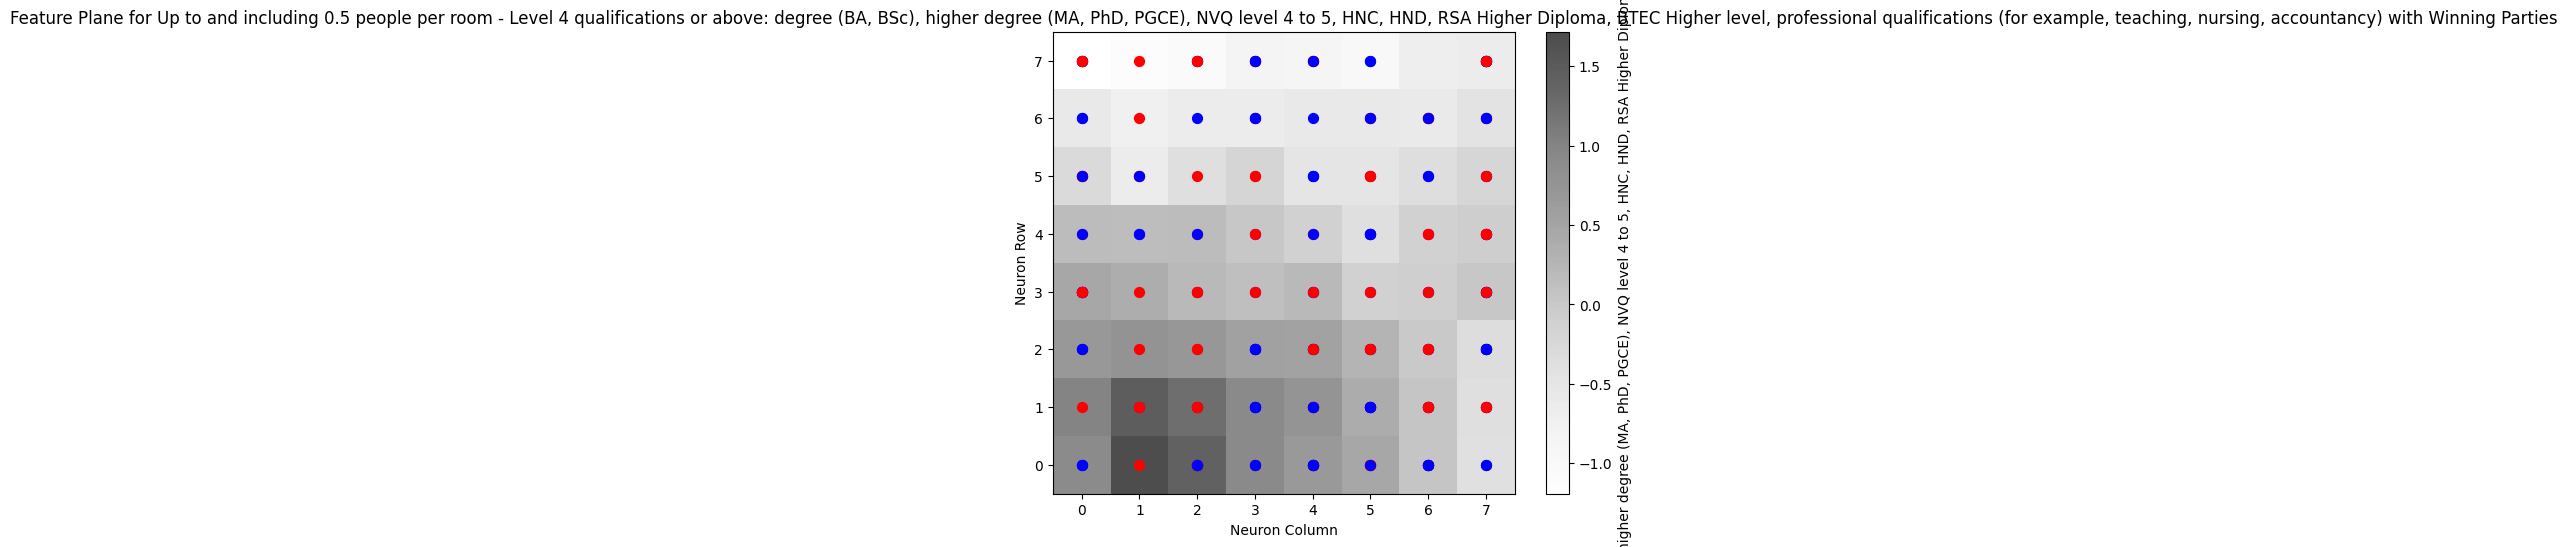

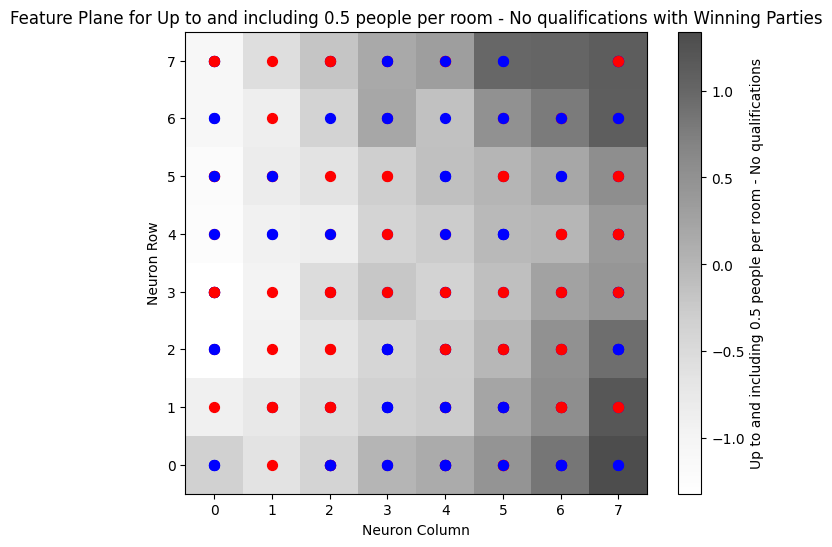

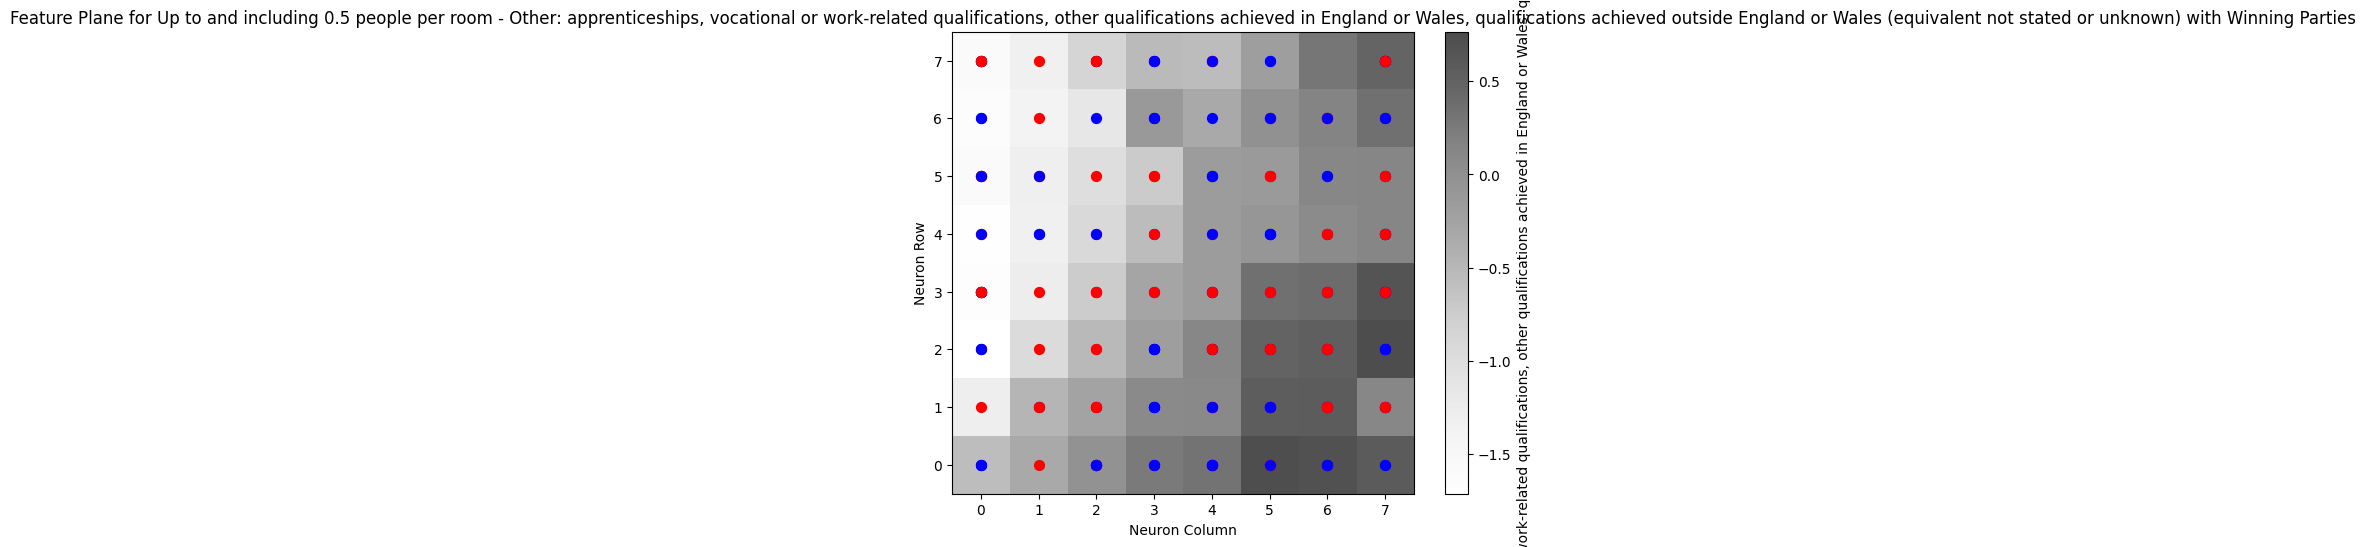

Neuron (6, 4): ['aldershot']
Neuron (1, 7): ['aldridgebrownhills', 'bootle', 'liverpool west derby', 'st helens south and whiston']
Neuron (1, 1): ['altrincham and sale west', 'oxford west and abingdon', 'south cambridgeshire']
Neuron (2, 7): ['amber valley', 'makerfield', 'redcar', 'south shields', 'st helens north']
Neuron (6, 7): ['ashfield', 'hemsworth', 'north west norfolk']
Neuron (4, 5): ['basingstoke', 'east worthing and shoreham', 'old bexley and sidcup', 'portsmouth north']
Neuron (0, 6): ['bassetlaw', 'bishop auckland', 'carlisle', 'east yorkshire', 'north durham', 'sedgefield']
Neuron (0, 0): ['bath', 'city of durham', 'norwich south']
Neuron (6, 3): ['batley and spen', 'burnley', 'hyndburn']
Neuron (2, 0): ['battersea', 'chelsea and fulham', 'islington south and finsbury']
Neuron (4, 0): ['bermondsey and old southwark', 'greenwich and woolwich']
Neuron (7, 3): ['birmingham yardley', 'oldham east and saddleworth', 'rochdale', 'walsall south']
Neuron (7, 2): ['blackley and b

In [33]:
#U*-Matrix plotting implementation(Combination of a density matrix and distance matrix)
from scipy.ndimage import median_filter

u_matrix = som.distance_map()# this is the distance matrix
# This process was emulated from a cited paper within the report of the u*-matrix
#plotting the two dimensional grid
density_matrix = np.zeros((n_neurons, m_neurons))

for r, c in zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']):
    density_matrix[r, c] += 1  # Count occurrences

# Normalize density values to avoid division errors
density_matrix = median_filter(density_matrix, size=3)  # to avoid division by zero

# Step 3: Compute the U*-Matrix
min_p = np.min(density_matrix)
mean_p = np.mean(density_matrix)

if mean_p - min_p == 0:
    scale_factor = np.ones_like(density_matrix)
else:
    scale_factor = (density_matrix - min_p) / (mean_p - min_p)
u_star_matrix = u_matrix * scale_factor

#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U*-Matrix with Overlaid Winning Parties")
plt.imshow(u_star_matrix.T, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar(label="Neuron Distance (U*-Matrix)")

# Overlayying the winning parties on the grid
for _, row in normalized_df.iterrows():
    neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
    party = row['Winning Party']
    vote_share = row['Winning Vote Share']

    if party in party_colors:
        base_color = np.array(party_colors[party])
        adjusted_color = np.clip(base_color * vote_share, 0, 1)

        plt.scatter(neuron_col, #+ 0.3 * np.random.rand(),
                    neuron_row, #+ 0.3 * np.random.rand(),
                    s=vote_share * 100,
                    color=adjusted_color,
                    alpha=0.7, edgecolors='k')

# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()


#The feature planes plotted so as to see how each constituency votes based on the feature category
for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {features.columns[feature_index]} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    for index, row in normalized_df.iterrows():
        neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        winning_party = row['Winning Party']
        if winning_party in party_colors:
          plt.scatter(neuron_col, neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=50)

    plt.show()


# Neuron-Constituency Mapping for cluster analysis and understanding
neuron_constituency_map = {}
for index, row in normalized_df.iterrows():
    neuron = (row['Neuron Row'], row['Neuron Col'])
    constituency = row['Westminster Parliamentary constituencies']
    if neuron not in neuron_constituency_map:
        neuron_constituency_map[neuron] = []
    neuron_constituency_map[neuron].append(constituency)


# Print the constituencies mapped to each neuron
for neuron, constituencies in neuron_constituency_map.items():
    print(f"Neuron {neuron}: {constituencies}")





normalized_df['Neuron'] = list(zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']))
# Party Distribution of the winning neurons with its vote share dataset for analysis
grouped = normalized_df.groupby("Neuron").agg({
    'Winning Party': lambda x: x.value_counts().to_dict(),
    'Winning Vote Share': 'mean',
}).rename(columns={
    'Winning Party': 'Party Distribution',
    'Winning Vote Share': 'Avg Vote Share',
})

print(grouped.head())
